In [1]:
#!pip uninstall -y "tensorflow" "tensorflow-gpu"
#!pip install "tensorflow-gpu==2.5.0"

In [2]:
!pip list | grep tensorflow

tensorflow                     2.4.1
tensorflow-addons              0.12.1
tensorflow-cloud               0.1.13
tensorflow-datasets            3.0.0
tensorflow-estimator           2.4.0
tensorflow-gcs-config          2.1.7
tensorflow-hub                 0.11.0
tensorflow-metadata            0.29.0
tensorflow-probability         0.12.1


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4895511148900699544
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15685569792
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6428041476129186802
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [4]:
import os
import numpy as np 
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

print(os.listdir('/kaggle/input'))
print(tf.version.VERSION)
print(tf.test.gpu_device_name())

['maskhq-onlymask']
2.4.1
/device:GPU:0


In [5]:
INPUT_PATH = '/kaggle/input/maskhq-onlymask'
TRAIN_PATH = os.path.join(INPUT_PATH, 'train')
MASK_PATH = os.path.join(INPUT_PATH, 'mask')

img_size=572
batch_size=128
channels=1
input_shape=(batch_size, img_size, img_size, channels)

In [6]:
# Image.open(os.path.join(TRAIN_PATH, '0.jpg')).size
files = os.listdir(TRAIN_PATH)
masks = os.listdir(MASK_PATH)

In [7]:
files = sorted(files, key=lambda x : int(x.split(".")[0])) # all end with jpg
masks = sorted(masks, key=lambda x : int(x.split(".")[0])) # all end with png

In [8]:
_files = files[:]
_masks = masks[:]

x_test = files[1000:1100]
y_test = masks[1000:1100]
files = files[:1000]
masks = masks[:1000]

In [9]:
images = tf.constant(files)
masks = tf.constant(masks)

In [10]:
def parse_function(filename, label):
    filename = filename.numpy().decode()
    label = label.numpy().decode()
#     print(filename, label)
    
    assert os.path.isfile(os.path.join(TRAIN_PATH, filename))
    image_string = tf.io.read_file(os.path.join(TRAIN_PATH, filename))
    image_decoded = tf.image.decode_image(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = tf.image.resize(image, (572, 572), preserve_aspect_ratio=True)
    image = tf.image.rgb_to_grayscale(image)
    image = image / 255.0
    image = tf.expand_dims(image, 0)
    
    assert os.path.isfile(os.path.join(MASK_PATH, label))
    label_string = tf.io.read_file(os.path.join(MASK_PATH, label))
    label_decoded = tf.io.decode_image(label_string, channels=1)
    label = tf.cast(label_decoded, tf.float32)
    label = tf.image.resize(label, (388, 388), preserve_aspect_ratio=True)
    label = tf.transpose(label, perm=(2, 0, 1))
    label = label / 255.0
    return image, label

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((images, masks))
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.map(lambda x, y : tf.py_function(parse_function, [x, y], [tf.float32, tf.float32]))
dataset = dataset.cache()

In [12]:
train = dataset.take(1000-100)
val = dataset.take(100)

In [13]:
def down_block(x, filters, kernel_size=3, padding="valid", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2), padding=padding)(c)
    return c, p

def up_block(x, skip, filters, kernel_size=3, padding="valid", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    print(f"skip_shape={skip.shape}, us_shape={us.shape}")
    skip = tf.keras.layers.Cropping2D(abs(us.shape[1] - skip.shape[1]) // 2)(skip)
    print(f"skip_shape={skip.shape}, us_shape={us.shape}")
    assert skip.shape[1] == us.shape[1]
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=3, padding="valid", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def make_model(inputs, img_size, batch_size):
    f = [64, 128, 256, 512, 1024]
    x = tf.keras.layers.Input((img_size, img_size, 1))
    
    c0, p0 = down_block(x, f[0]) # 512->256
    print(c0.shape, p0.shape)
    c1, p1 = down_block(p0, f[1]) # 256->128
    print(c1.shape, p1.shape)
    c2, p2 = down_block(p1, f[2]) # 128->64
    print(c2.shape, p2.shape)
    c3, p3 = down_block(p2, f[3]) # 64->32
    print(c3.shape, p3.shape)
    
    c4 = bottleneck(p3, f[4])
    print(c4.shape)
    
    c5 = up_block(c4, c3, f[3])
    c6 = up_block(c5, c2, f[2])
    c7 = up_block(c6, c1, f[1])
    c8 = up_block(c7, c0, f[0])
    
    c9 = tf.keras.layers.Conv2D(2, 1, strides=1, padding="valid", activation="softmax")(c8)
    
    model = tf.keras.Model(inputs=x, outputs=c9)
    
    return model

In [14]:
model = make_model(dataset, img_size, batch_size)
# tf.keras.utils.plot_model(model, show_shapes=True)

(None, 568, 568, 64) (None, 284, 284, 64)
(None, 280, 280, 128) (None, 140, 140, 128)
(None, 136, 136, 256) (None, 68, 68, 256)
(None, 64, 64, 512) (None, 32, 32, 512)
(None, 28, 28, 1024)
skip_shape=(None, 64, 64, 512), us_shape=(None, 56, 56, 1024)
skip_shape=(None, 56, 56, 512), us_shape=(None, 56, 56, 1024)
skip_shape=(None, 136, 136, 256), us_shape=(None, 104, 104, 512)
skip_shape=(None, 104, 104, 256), us_shape=(None, 104, 104, 512)
skip_shape=(None, 280, 280, 128), us_shape=(None, 200, 200, 256)
skip_shape=(None, 200, 200, 128), us_shape=(None, 200, 200, 256)
skip_shape=(None, 568, 568, 64), us_shape=(None, 392, 392, 128)
skip_shape=(None, 392, 392, 64), us_shape=(None, 392, 392, 128)


In [15]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.99),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [16]:
hist = model.fit(
    train,
    batch_size=1,
    epochs=15,
    shuffle=True,
    validation_data=val,
)

Epoch 1/15
900/900 [==============================] - 150s 161ms/step - loss: 0.6494 - val_loss: 0.6213
Epoch 2/15
900/900 [==============================] - 125s 139ms/step - loss: 0.6268 - val_loss: 0.6250
Epoch 3/15
900/900 [==============================] - 124s 137ms/step - loss: 0.6321 - val_loss: 0.6260
Epoch 4/15
900/900 [==============================] - 123s 137ms/step - loss: 0.6253 - val_loss: 0.6053
Epoch 5/15
900/900 [==============================] - 123s 136ms/step - loss: 0.5944 - val_loss: 0.5774
Epoch 6/15
900/900 [==============================] - 123s 137ms/step - loss: 0.5735 - val_loss: 0.5909
Epoch 7/15
900/900 [==============================] - 123s 137ms/step - loss: 0.5776 - val_loss: 0.5490
Epoch 8/15
900/900 [==============================] - 123s 137ms/step - loss: 0.5625 - val_loss: 0.5389
Epoch 9/15
900/900 [==============================] - 123s 136ms/step - loss: 0.5535 - val_loss: 0.5749
Epoch 10/15
900/900 [==============================] - 123s 137m

In [17]:
# hist.history

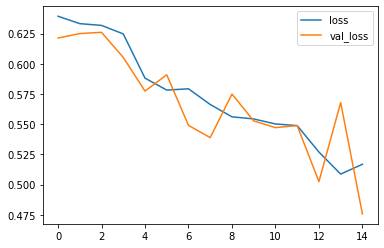

In [18]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.close()

In [19]:
# plt.plot(hist.history['sparse_categorical_accuracy'], label='acc')
# plt.plot(hist.history['val_sparse_categorical_accuracy'], label='val_acc')
# plt.legend()
# plt.show()
# plt.close()

In [20]:
test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test = test.map(lambda x, y : tf.py_function(parse_function, [x, y], [tf.float32, tf.float32]))
test = test.cache()

In [21]:
results = model.evaluate(test, batch_size=1)

100/100 [==============================] - 7s 74ms/step - loss: 0.5048


In [22]:
print(results)

0.5048388242721558


In [23]:
i = test.take(1)
i = list(i)
test_img, truth = i[0]

In [24]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        print(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [25]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

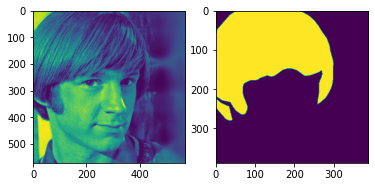

In [26]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(np.squeeze(test_img))
ax[1].imshow(np.squeeze(truth))
plt.show()
plt.close()

Input Image
True Mask
Predicted Mask


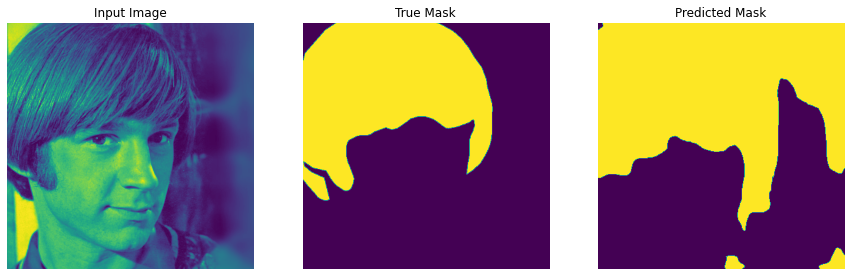

In [27]:
prediction = model.predict(test_img)
display([test_img[0], truth[0][..., tf.newaxis], create_mask(prediction)])

In [28]:
i = train.take(1)
i = list(i)
train_img, truth = i[0]

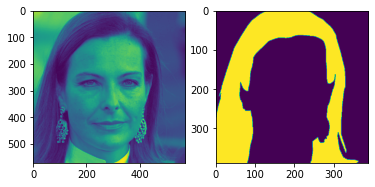

In [29]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(np.squeeze(train_img))
ax[1].imshow(np.squeeze(truth))
plt.show()
plt.close()

Input Image
True Mask
Predicted Mask


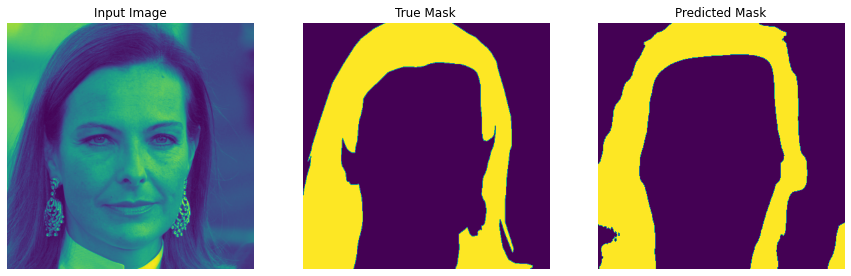

In [30]:
prediction = model.predict(train_img)
display([train_img[0], truth[0][..., tf.newaxis], create_mask(prediction)])

In [31]:
# model.save_weights("/kaggle/working/July5-10AM")
# model.save("/kaggle/working/July5-10AM.h5")